In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Pre-Processing, Model selection and Evaluation Libraries
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE #CPU wont be able to process large datasets with TSNE. Try GPU instead.
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, KFold,StratifiedKFold,StratifiedShuffleSplit,cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline

from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.metrics import classification_report_imbalanced

#Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

#Other Libraries
import time 
import os
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# _I - Understanding the Data_

### 1. Load and View the Data

In [2]:
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2. Check for Missing Values

In [3]:
# Checking for Null Values
df.isna().sum().sum() 

0

### 3. Check for Class Imbalance

In [4]:
# Checking Data Imbalance - Classes are heavily skewed
print('Non Fraud Cases:',round(df.Class.value_counts(normalize = True)*100, 2)[0], '%')
print('Fraud Cases:',round(df.Class.value_counts(normalize = True)*100, 2)[1], '%')

Non Fraud Cases: 99.83 %
Fraud Cases: 0.17 %


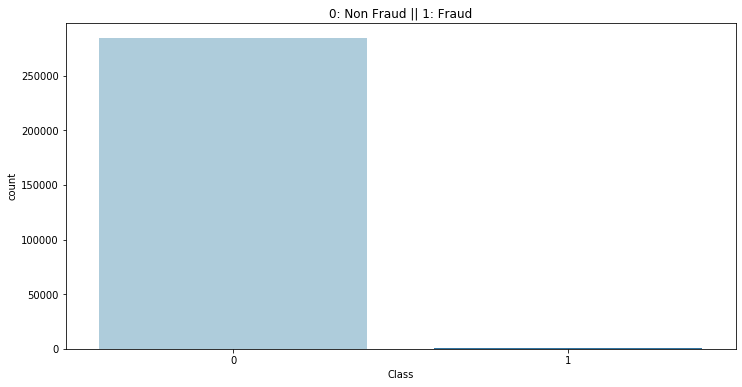

In [5]:
# Plotting Class Imbalance
plt.figure(figsize = (12,6))
sns.countplot(df.Class,palette = sns.color_palette("Paired", 3))
plt.title('0: Non Fraud || 1: Fraud')
plt.show()

### 4. Distributions of Unscaled Features

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

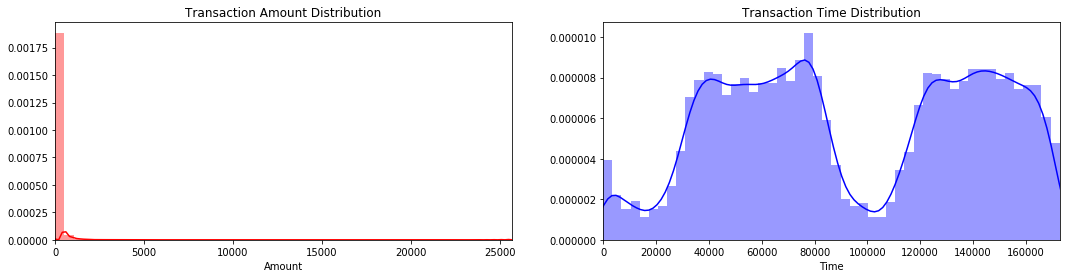

In [7]:
# Checking Distributions of Known and Unscaled Featues - Time and Amount

fig, ax = plt.subplots(1,2, figsize = (18,4))

sns.distplot(df.Amount, ax = ax[0], color = 'r')
ax[0].set_title('Transaction Amount Distribution')
ax[0].set_xlim(min(df.Amount), max(df.Amount))

sns.distplot(df.Time, ax = ax[1], color = 'b')
ax[1].set_title('Transaction Time Distribution')
ax[1].set_xlim(min(df.Time), max(df.Time))

plt.show()

# _II - Pre Processing_

## A - Scaling and Distribution

In [8]:
# Scaling Columns - Time and Amount 

rob_scaler = RobustScaler() #Robust Scaler is less affected by Outliers
df['Time'] = rob_scaler.fit_transform(df[['Time']])
df['Amount'] = rob_scaler.fit_transform(df[['Amount']])

# Changing the order of the columns. Bringing Amount and Time to the front

scaled_time = df['Time']
scaled_amount = df['Amount']

df.drop(['Time', 'Amount'], 1, inplace = True)

df.insert(0, 'Amount', scaled_amount)
df.insert(1, 'Time', scaled_time)

df.head()

,Amount,Time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## B - Splitting the DataFrame

In [9]:
X = df.drop('Class',1)
y = df.Class

skf = StratifiedKFold(n_splits = 5, random_state = 0, shuffle = False)

# Checking if the splits are proportionate
n = 1
for train_index, test_index in skf.split(X,y):
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]
    
    print('Split {} \n'.format(n))
    n = n+1
    
    # Checking Label Distribution for Train Set
    train_not_fraud = round(original_ytrain.value_counts(normalize = True)*100, 2)[0]
    train_fraud = round(original_ytrain.value_counts(normalize = True)*100, 2)[1]
    
    print('Train Set:')
    print('Not Fraud: {}'.format(train_not_fraud))
    print('Fraud: {}'.format(train_fraud))
    
    # Checking Label Distribution for Train Set
    test_not_fraud = round(original_ytest.value_counts(normalize = True)*100, 2)[0]
    test_fraud = round(original_ytest.value_counts(normalize = True)*100, 2)[1]
    
    print('Test Set:')
    print('Not Fraud: {}'.format(test_not_fraud))
    print('Fraud: {}'.format(test_fraud))    
    
    print('-'*100)

Split 1 

Train Set:
Not Fraud: 99.83
Fraud: 0.17
Test Set:
Not Fraud: 99.83
Fraud: 0.17
----------------------------------------------------------------------------------------------------
Split 2 

Train Set:
Not Fraud: 99.83
Fraud: 0.17
Test Set:
Not Fraud: 99.83
Fraud: 0.17
----------------------------------------------------------------------------------------------------
Split 3 

Train Set:
Not Fraud: 99.83
Fraud: 0.17
Test Set:
Not Fraud: 99.83
Fraud: 0.17
----------------------------------------------------------------------------------------------------
Split 4 

Train Set:
Not Fraud: 99.83
Fraud: 0.17
Test Set:
Not Fraud: 99.83
Fraud: 0.17
----------------------------------------------------------------------------------------------------
Split 5 

Train Set:
Not Fraud: 99.83
Fraud: 0.17
Test Set:
Not Fraud: 99.83
Fraud: 0.17
----------------------------------------------------------------------------------------------------


# _III - UnderSampling and OverSampling_

## A - Distributing and Correlating

### 1. Randomly Under Sampling Data

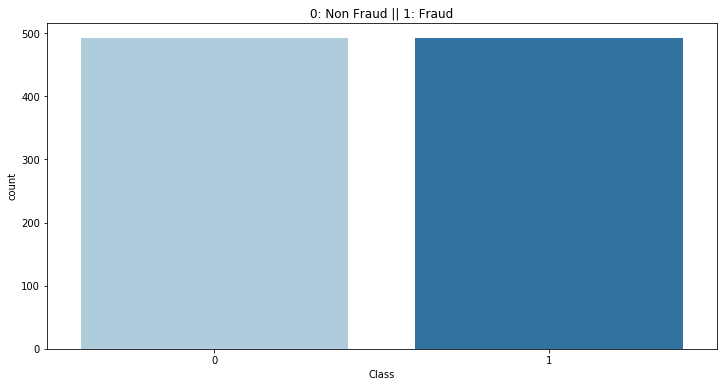

In [9]:
#Randomizing df so non_fraud_df could be be randomized
df = df.sample(frac = 1)

#Subsetting the DataFrame
fraud_df = df[df['Class'] == 1]
len_fraud_df = len(fraud_df)

non_fraud_df = df[df['Class'] == 0][:len_fraud_df]

#Combining into a new dataframe and randomizing it
new_df = pd.concat([fraud_df, non_fraud_df]).sample(frac = 1, random_state = 42)
# Plotting the Class Distribution in new_df
plt.figure(figsize = (12,6))
sns.countplot(new_df.Class,palette = sns.color_palette("Paired", 3))
plt.title('0: Non Fraud || 1: Fraud')
plt.show()

### 2. Correlation Matrixes

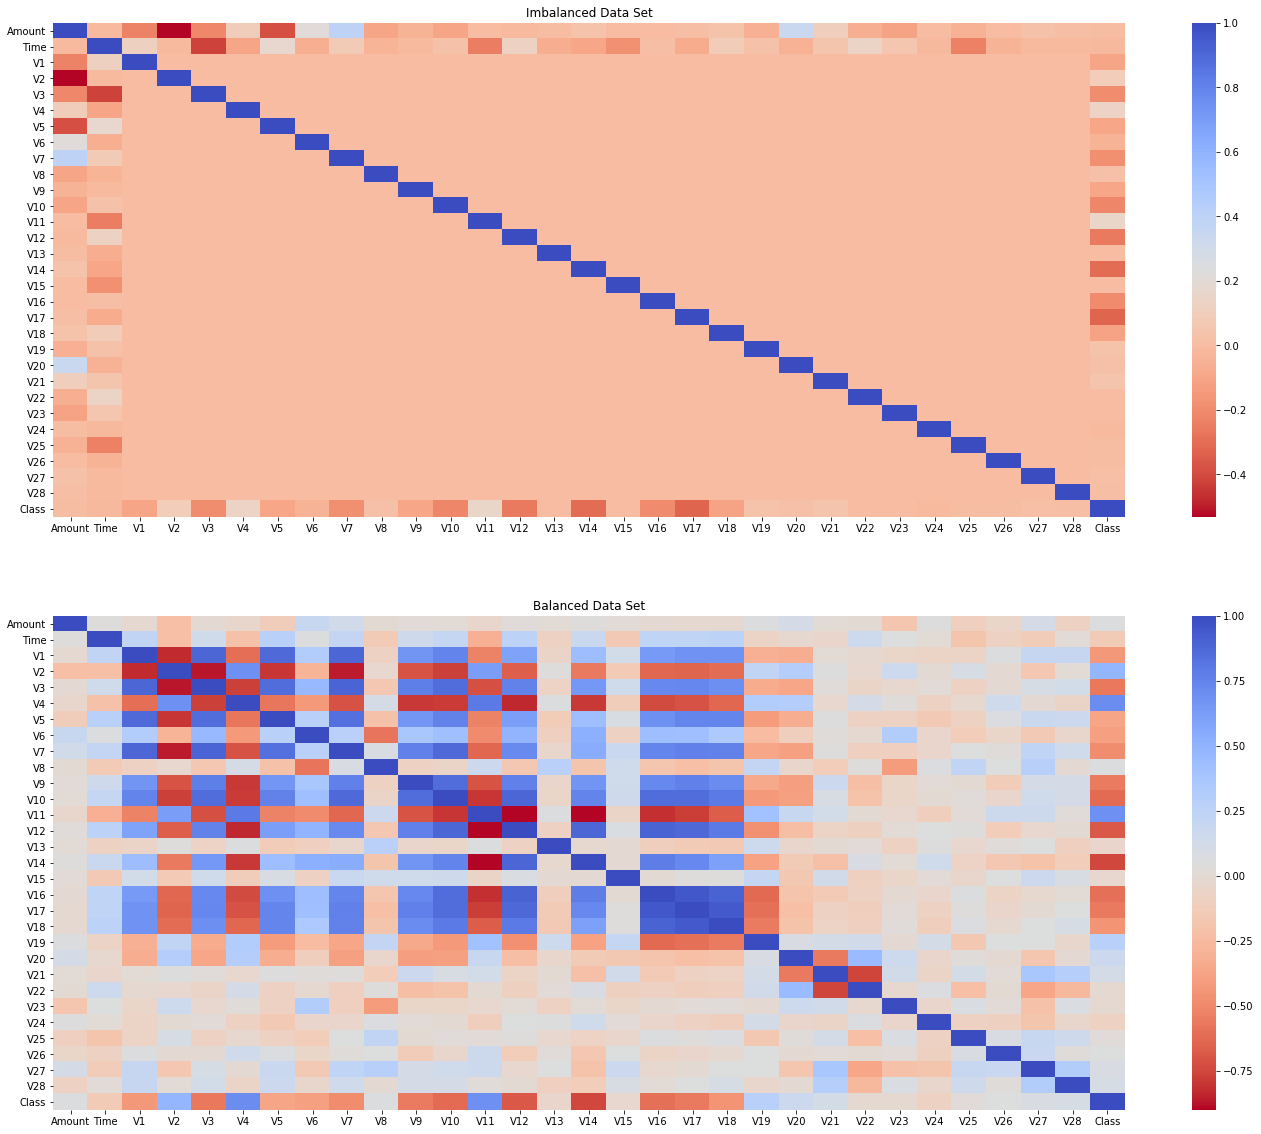

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize = (24,20))

# Entire DataFrame

sns.heatmap(df.corr(), annot = False, cmap = 'coolwarm_r',ax = ax1) # Annot decides if corr values should be shown in each cell
ax1.set_title('Imbalanced Data Set')

# UnderSampled and Balanced DataFrame

sns.heatmap(new_df.corr(),cmap = 'coolwarm_r', ax = ax2)
ax2.set_title('Balanced Data Set')

plt.show()

### 3. Boxplot Visualisation of Highly Correlated Features

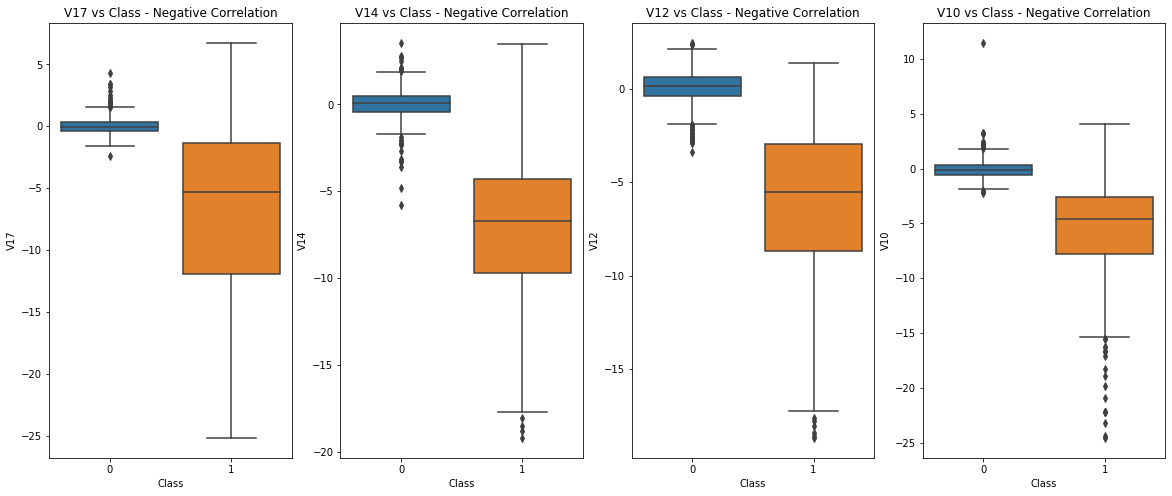

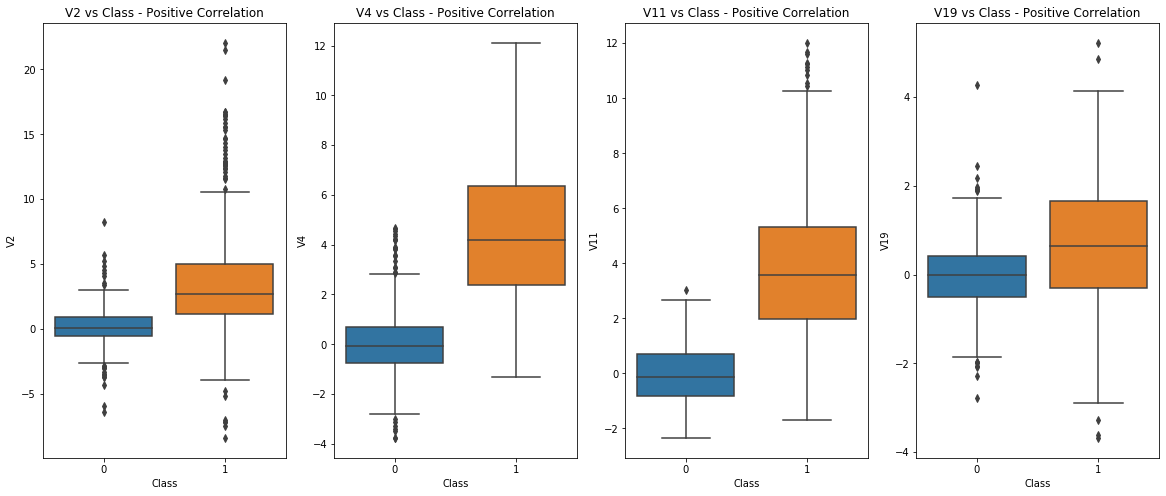

In [11]:
# Boxplots

# Boxplots for Negative Correlated Features
fig, ax = plt.subplots(1,4, figsize = (20,8))
neg_corr = ['V17','V14','V12','V10']
axes = [0,1,2,3]
neg_axes = list(zip(neg_corr, axes))

for feature, axis_no in neg_axes:
    sns.boxplot(x = 'Class', y = feature, data = new_df, ax = ax[axis_no])
    ax[axis_no].set_title('{} vs Class - Negative Correlation'.format(feature))

    
# Boxplots for positive Correlated Features
fig, ax = plt.subplots(1,4, figsize = (20,8))
pos_corr = ['V2','V4','V11','V19']
axes = [0,1,2,3]
pos_axes = list(zip(pos_corr, axes))

for feature, axis_no in pos_axes:
    sns.boxplot(x = 'Class', y = feature, data = new_df, ax = ax[axis_no])
    ax[axis_no].set_title('{} vs Class - Positive Correlation'.format(feature))

## B - Anomaly Detection

### 1. Visualise Distributions 

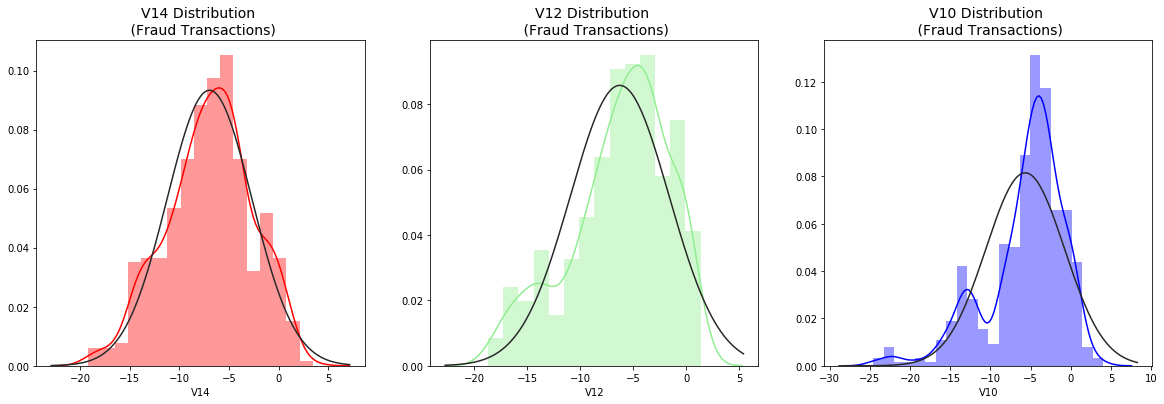

In [12]:
from scipy.stats import norm # To have a normal distribution line to compare our actual distributions to.

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,6))

v14_fraud_dist = new_df[new_df['Class'] == 1]['V14']
sns.distplot(v14_fraud_dist, ax = ax1, color = 'red', fit = norm)
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df[new_df['Class'] == 1]['V12']
sns.distplot(v12_fraud_dist, ax = ax2, color = 'lightgreen', fit = norm)
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)

v10_fraud_dist = new_df[new_df['Class'] == 1]['V10']
sns.distplot(v10_fraud_dist, ax = ax3, color = 'blue', fit = norm)
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

### 2. Outlier Removal

In [13]:
# V14 Outlier Removal 

q25, q75 = np.percentile(v14_fraud_dist, 25), np.percentile(v14_fraud_dist, 75)
print('Quartile 25:', q25)
print('Quartile 75:', q75)
v14_iqr = q75 - q25
print('IQR:', v14_iqr)

v14_lower = q25 - 1.5*v14_iqr
v14_upper = q75 + 1.5*v14_iqr
print('V14 Range: {}'.format([v14_lower, v14_upper]))

outliers = [x for x in v14_fraud_dist if x < v14_lower or x > v14_upper]
print('Outliers:', outliers)
print('Total Number of Outliers:', len(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] < v14_lower) | (new_df['V14'] > v14_upper)].index)
print('No of instances after Outlier Removal:', len(new_df))

print('-'*345)

# V12 Outlier Removal 

v12_fraud_dist = new_df[new_df['Class'] == 1]['V12']
q25, q75 = np.percentile(v12_fraud_dist, 25), np.percentile(v12_fraud_dist, 75)
print('Quartile 25:', q25)
print('Quartile 75:', q75)
v12_iqr = q75 - q25
print('IQR:', v12_iqr)

v12_lower = q25 - 1.5*v12_iqr
v12_upper = q75 + 1.5*v12_iqr
print('V12 Range: {}'.format([v12_lower, v12_upper]))

outliers = [x for x in v12_fraud_dist if x < v12_lower or x > v12_upper]
print('Outliers:', outliers)
print('Total Number of Outliers:', len(outliers))

new_df = new_df.drop(new_df[(new_df['V12'] < v12_lower) | (new_df['V12'] > v12_upper)].index)
print('No of instances after Outlier Removal:', len(new_df))

print('-'*345)

# V10 Outlier Removal 

v10_fraud_dist = new_df[new_df['Class'] == 1]['V10']
q25, q75 = np.percentile(v10_fraud_dist, 25), np.percentile(v10_fraud_dist, 75)
print('Quartile 25:', q25)
print('Quartile 75:', q75)
v10_iqr = q75 - q25
print('IQR:', v10_iqr)

v10_lower = q25 - 1.5*v10_iqr
v10_upper = q75 + 1.5*v10_iqr
print('V10 Range: {}'.format([v10_lower, v10_upper]))

outliers = [x for x in v10_fraud_dist if x < v10_lower or x > v10_upper]
print('Outliers:', outliers)
print('Total Number of Outliers:', len(outliers))

new_df = new_df.drop(new_df[(new_df['V10'] < v10_lower) | (new_df['V10'] > v10_upper)].index)
print('No of instances after Outlier Removal:', len(new_df))

print('-'*345)

Quartile 25: -9.692722964972385
Quartile 75: -4.282820849486866
IQR: 5.409902115485519
V14 Range: [-17.807576138200663, 3.8320323237414122]
Outliers: [-18.049997689859396, -18.8220867423816, -19.2143254902614, -18.4937733551053]
Total Number of Outliers: 4
No of instances after Outlier Removal: 980
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Quartile 25: -8.67303320439115
Quartile 75: -2.893030568676315
IQR: 5.780002635714835
V12 Range: [-17.3430371579634, 5.776973384895937]
Outliers: [-18.4311310279993, -18.047596570821604, -18.683714633344298, -18.553697009645802]
Total Number of Outliers: 4
No of instances after Outlier Removal: 976
------------------------------------------------------

### 3. Plotting the Box plots for the revised Data set (new_df Post Outlier removal)

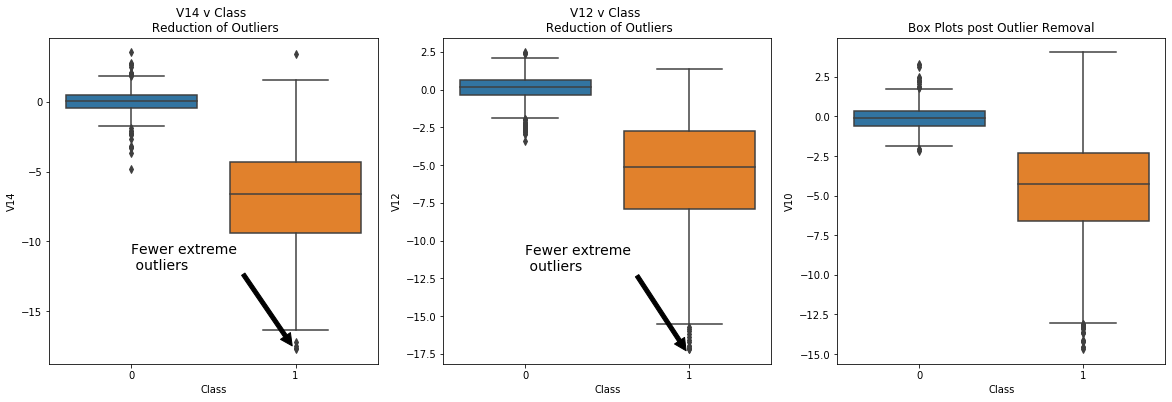

In [14]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,6))

sns.boxplot(x = 'Class', y = 'V14', data = new_df, ax = ax1)
ax1.set_title('V14 v Class \n Reduction of Outliers')
ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)


sns.boxplot(x = 'Class', y = 'V12', data = new_df, ax = ax2)
ax2.set_title('V12 v Class \n Reduction of Outliers')
ax2.annotate('Fewer extreme \n outliers', xy=(0.98, -17.3), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

sns.boxplot(x = 'Class', y = 'V10', data = new_df, ax = ax3)
ax3.set_title('V10 v Class \n Reduction of Outliers')
ax3.annotate('Fewer extreme \n outliers', xy=(0.95, -16.5), xytext=(0, -12),
            arrowprops=dict(facecolor='black'),
            fontsize=14)

plt.title('Box Plots post Outlier Removal')
plt.show()

## C - Dimensionality Reduction and Clustering

In [15]:
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))


T-SNE took 7.1 s
PCA took 0.057 s
Truncated SVD took 0.0053 s


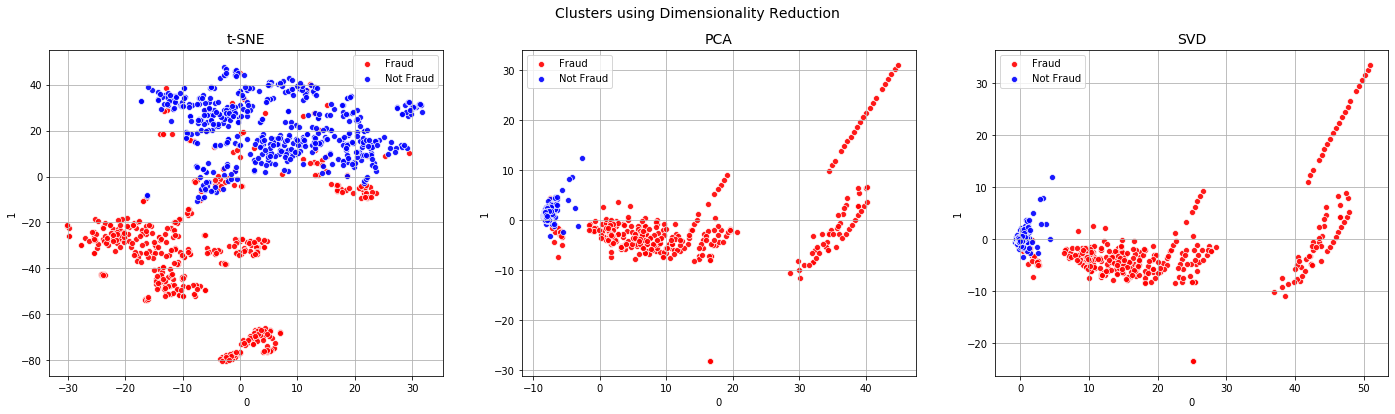

In [16]:
import matplotlib.patches as mpatches

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


# t-SNE scatter plot
tsne_df = pd.concat([pd.DataFrame(X_reduced_tsne), pd.DataFrame(y.values, columns = ['Class'])], 1)

sns.scatterplot(tsne_df[tsne_df.Class == 1][0], tsne_df[tsne_df.Class == 1][1],
                label = 'Fraud', alpha = 0.9, color = 'red', ax = ax1)
sns.scatterplot(tsne_df[tsne_df.Class == 0][0], tsne_df[tsne_df.Class == 0][1],
                label = 'Not Fraud', alpha = 0.9, color = 'blue', ax = ax1)
ax1.set_title('t-SNE', fontsize=14)
ax1.grid(True)



# PCA Scatter Plot
pca_df = pd.concat([pd.DataFrame(X_reduced_pca), pd.DataFrame(y.values, columns = ['Class'])], 1)

sns.scatterplot(pca_df[pca_df.Class == 1][0], pca_df[pca_df.Class == 1][1],
               label = 'Fraud', alpha = 0.9, color = 'red', ax = ax2)
sns.scatterplot(pca_df[pca_df.Class == 0][0], pca_df[pca_df.Class == 0][1],
               label = 'Not Fraud', alpha = 0.9, color = 'blue', ax = ax2)
ax2.set_title('PCA', fontsize = 14)
ax2.grid(True)



#TruncatedSVD
svd_df = pd.concat([pd.DataFrame(X_reduced_svd), pd.DataFrame(y.values, columns = ['Class'])], 1)
sns.scatterplot(svd_df[svd_df.Class == 1][0], svd_df[svd_df.Class == 1][1],
               label = 'Fraud', alpha = 0.9, color = 'red', ax = ax3)
sns.scatterplot(svd_df[svd_df.Class == 0][0], svd_df[svd_df.Class == 0][1],
               label = 'Not Fraud', alpha = 0.9, color = 'blue', ax = ax3)
ax3.set_title('SVD', fontsize = 14)
ax3.grid(True)


## D - Classifiers

### 1. Cross Val Scores

In [17]:
# Train-Test Split
print(new_df.shape)

import time

t0 = time.time()

X = new_df.drop('Class', axis=1)
y = new_df['Class']

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0, test_size = 0.2)

# Classifiers

classifiers = {'Logistic Regression': LogisticRegression(),
              'KNN': KNeighborsClassifier(),
              'Support Vector Classifier': SVC(),
              'Decision Tree Classifier': DecisionTreeClassifier()}

for key, classifier in classifiers.items():
    score = cross_val_score(classifier, X_train,y_train,cv = 5 ).mean()*100
    print(key, score)
    
print('Time Taken:', (time.time() - t0))

(948, 31)
Logistic Regression 93.13872429417917
KNN 92.8738236319275
Support Vector Classifier 92.87120948065528
Decision Tree Classifier 90.63001045660508
Time Taken: 0.43523311614990234


### 2. Grid Search CV

In [18]:
from sklearn.model_selection import GridSearchCV


log_reg_params = {'penalty': ['l1','l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_grid = GridSearchCV(LogisticRegression(), param_grid = log_reg_params)
log_reg_grid.fit(X_train, y_train)


knears_params = {'n_neighbors': list(range(1,11)), 'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']}
knears_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knears_params)
knears_grid.fit(X_train, y_train)


svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
svc_grid = GridSearchCV(SVC(), param_grid = svc_params)
svc_grid.fit(X_train, y_train)


decision_tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,6,1)), 
              "min_samples_leaf": list(range(5,7,1))}
decision_tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid = decision_tree_params)
decision_tree_grid.fit(X_train, y_train)


log_reg_grid.best_params_.items()

dict_items([('C', 100), ('penalty', 'l2')])

### 3. Cross Val Scores of Best Estimators

In [19]:
# Cross - Val Scores of Best Estimators

log_reg_score = cross_val_score(log_reg_grid.best_estimator_, X_train, y_train, cv=5).mean() # can also use .best_score_ directly
print('Logistic Regression:', log_reg_score)

knears_score = cross_val_score(knears_grid.best_estimator_, X_train, y_train, cv=5).mean()
print('K nears Classifier:', knears_score)

svc_score = cross_val_score(svc_grid.best_estimator_, X_train, y_train, cv=5).mean()
print('Support Vector Classifier:', svc_score)

decision_tree_score = cross_val_score(decision_tree_grid.best_estimator_, X_train, y_train, cv=5).mean()
print('Decision Tree Classifier:', decision_tree_score)


# adding Cross Val Scores to a DataFrame
scores_df = pd.DataFrame([log_reg_score, knears_score, svc_score, decision_tree_score], columns = ['Cross Val Acc.'],
            index = ['Log Regression','K Nears', 'Support Vectors', 'Decision Trees'])

Logistic Regression: 0.9406326246078773
K nears Classifier: 0.9313698152666434
Support Vector Classifier: 0.932729173928198
Decision Tree Classifier: 0.9287643778319973


### 4. ROC AUC Scores of Best Estimators

In [20]:
# ROC AUC Score of Best Estimtors

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict


log_reg_pred = cross_val_predict(log_reg_grid.best_estimator_, X_train, y_train, cv=5,
                             method="decision_function")
print('ROC AUC Score Logistic Regression:',roc_auc_score(y_train, log_reg_pred))


knears_pred = cross_val_predict(knears_grid.best_estimator_, X_train, y_train, cv = 5,)
print('ROC AUC Score K Neighbors Classifier:',roc_auc_score(y_train, knears_pred))

svc_pred = cross_val_predict(svc_grid.best_estimator_, X_train, y_train, cv=5,
                             method="decision_function")
print('ROC AUC Score Support Vector Classifier:',roc_auc_score(y_train, svc_pred))


tree_pred = cross_val_predict(decision_tree_grid.best_estimator_, X_train, y_train, cv=5)
print('ROC AUC Score Decision Tree Classifier:',roc_auc_score(y_train, tree_pred))


# Updating Scores_df with ROC AUC Scores
scores_df['ROC AUC'] = [roc_auc_score(y_train, log_reg_pred), roc_auc_score(y_train, knears_pred),
                       roc_auc_score(y_train, svc_pred), roc_auc_score(y_train, tree_pred)]

ROC AUC Score Logistic Regression: 0.9745580081598493
ROC AUC Score K Neighbors Classifier: 0.92893259406493
ROC AUC Score Support Vector Classifier: 0.9753600446350735
ROC AUC Score Decision Tree Classifier: 0.9265857655961225


In [21]:
scores_df

,Cross Val Acc.,ROC AUC
Log Regression,0.940633,0.974558
K Nears,0.931370,0.928933
Support Vectors,0.932729,0.975360
Decision Trees,0.928764,0.926586


### 5. Visualising ROC AUC Curve for each Estimator

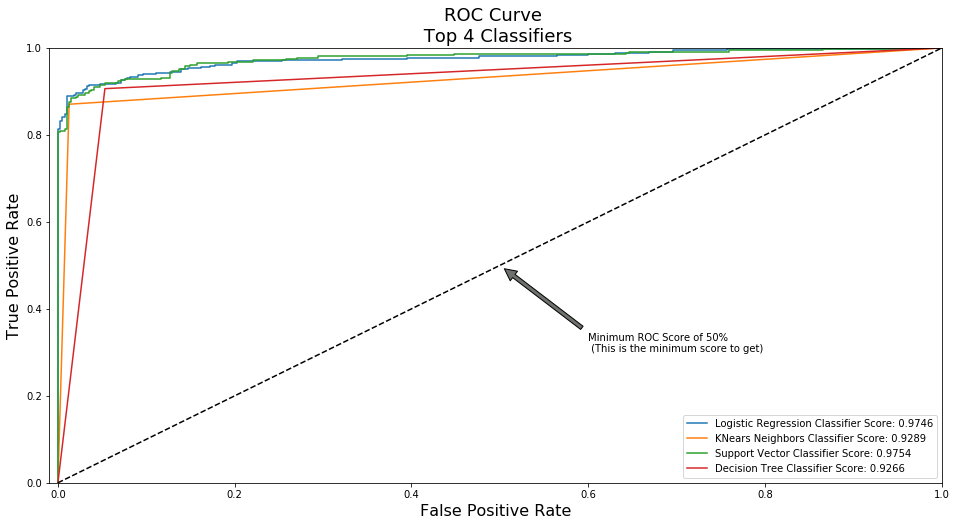

In [22]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

### 6. Best Model Evaluation Metrics on UnderSampled Data

In [23]:
# Evaluation Metrics on Randomly Undersampled Train Data
log_reg_pred = cross_val_predict(log_reg_grid.best_estimator_, X_train, y_train, cv=5,
                             method="predict")
print(accuracy_score(y_train, log_reg_pred))
print(roc_auc_score(y_train, log_reg_pred))
print(recall_score(y_train, log_reg_pred))
print(precision_score(y_train, log_reg_pred))
print(f1_score(y_train, log_reg_pred))
print(confusion_matrix(y_train, log_reg_pred))

0.9406332453825857
0.9395787564947519
0.9146005509641874
0.9595375722543352
0.9365303244005642
[[381  14]
 [ 31 332]]


In [24]:
# Evaluation Metics on Randomly UnderSampled Test Data
log_pred_test = log_reg_grid.best_estimator_.predict(X_test)

print(accuracy_score(y_test, log_pred_test))
print(roc_auc_score(y_test, log_pred_test))
print(recall_score(y_test, log_pred_test))
print(precision_score(y_test, log_pred_test))
print(f1_score(y_test, log_pred_test))

print(confusion_matrix(y_test, log_pred_test))

0.9526315789473684
0.9523492907801417
0.925531914893617
0.9775280898876404
0.9508196721311475
[[94  2]
 [ 7 87]]


### 7. Best Model Evaluation Metrics on Original Data

In [25]:
# Best Model Trained on Randomly Undersampled Data, being evaluated on Original Data
log_reg_pred_test = log_reg_grid.best_estimator_.predict(df.drop('Class',1))

print(accuracy_score(df.Class, log_reg_pred_test))
print(roc_auc_score(df.Class, log_reg_pred_test))
print(recall_score(df.Class, log_reg_pred_test))
print(precision_score(df.Class, log_reg_pred_test))
print(f1_score(df.Class, log_reg_pred_test))

print(confusion_matrix(df.Class, log_reg_pred_test))

0.9631680401113737
0.9440155943203383
0.9247967479674797
0.041712504583791714
0.07982456140350878
[[273862  10453]
 [    37    455]]


### 8. Evaluation Metrics on Original Data (of Model trained on Original Data)

In [26]:
X_train_orgi, X_test_orgi, y_train_orgi, y_test_orgi = train_test_split(df.drop('Class',1), df.Class, test_size = 0.2,
                                                                   random_state = 0)
log_reg_orgi = LogisticRegression().fit(X_train_orgi, y_train_orgi)
y_pred_orgi = log_reg_orgi.predict(X_test_orgi)

print(accuracy_score(y_test_orgi, y_pred_orgi))
print(roc_auc_score(y_test_orgi, y_pred_orgi))
print(recall_score(y_test_orgi, y_pred_orgi))
print(precision_score(y_test_orgi, y_pred_orgi))
print(f1_score(y_test_orgi, y_pred_orgi))

print(confusion_matrix(y_test_orgi, y_pred_orgi))

0.9992099996488887
0.8104471837796965
0.6210526315789474
0.8676470588235294
0.7239263803680981
[[56858     9]
 [   36    59]]


# IIII. Different Models and DataSet Comparisions

We have seen the Model performance on an Self Created Randomly UnderSampled DataSet to see how we can work with Imbalanced DataSets.
We will now explore different sampling techniques, which are also in-built classes in sklearn. 

The end goal here is to create a detailed table/DataFrame for us to compare each Sampling technique, and how it compares over different Classifier models and Evaluation Metrics.

The flow we will follow will be:

1. There will be 3 categories of DataSets - Original, UnderSampled and OverSampled. 
2. Techniques we will be using for UndeSampling are - Random UnderSampling, Cluster Centroids and Tomek Links
3. Techniques we will be using for OverSampling are - Random OverSampling and SMOTE
4. So including the Orginal Dataset, we will be working with 6 different Datasets.

For each of the 6 DataSets: 
- Use 5 different Classifiers - Logistic Regression, SVM, KNN, Decision Trees, XGBoost
- Using GridSearchCV, Find Best Estimator for each Classifier for each Dataset. 
- Under each DataSet, For Each Classifier(Best Estimated Model) - calculate Evaluation Metrics

Evaluation Metrics to be observed: 
1. Cross Val Accuracy 
2. ROC AUC Score
3. Precision Score
4. Recall Score
5. F1 Score
6. Confusion Matrix

## Notes: 
#### 1. Since this entire procedure will be extremely heavy on comoutation, we will work with just 10% of the original datset. We will stratisfy it to have the same distribution of fruad and non-fraud transactions as the original data.
#### 2. Even with taking 10% of the data, all these computations taken over 2 hours to happen. So we need to be patient.
#### 3. We expect the RandomUnderSampler Technique results to very closely or exactly resemble the above results, but we will redo it and add to the dataframe just to be sure. 

## A. Importing Libraries

In [27]:
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids, TomekLinks
from imblearn.over_sampling import RandomOverSampler, SMOTE
from xgboost import XGBClassifier
import time

## B. Creating Table Template

In [97]:
final_table = pd.DataFrame()
final_table['DataSet'] = ['Original']*5 + ['US Random']*5 + ['US ClusterCentroids']*5 + ['US TomekLinks']*5 \
                            +['OS Random']*5 + ['OS SMOTE']*5
final_table['Model'] = ['Logistic Regression','Support Vectors', 'K Neighbors', 'Decision Trees', 'XGBoost']*6
final_table['Best Estimator'] = ''
final_table['Cross Val Acc.'] = ''
final_table['Accuracy Score'], final_table['ROC AUC Score'], final_table['Recall Score'] = '' , '' , ''
final_table['Precision Score'], final_table['F1 Score'], final_table['Confusion Matrix'] = '' , '' , ''

print(final_table.shape)

final_table.head()

(30, 10)


,DataSet,Model,Best Estimator,Cross Val Acc.,Accuracy Score,ROC AUC Score,Recall Score,Precision Score,F1 Score,Confusion Matrix
0,Original,Logistic Regression,,,,,,,,
1,Original,Support Vectors,,,,,,,,
2,Original,K Neighbors,,,,,,,,
3,Original,Decision Trees,,,,,,,,
4,Original,XGBoost,,,,,,,,


## C. Evaluation over Different DataSets

### Classifier Functions (to perform Grid Search and calculate Evaluation Metrics)

In [62]:

# Logistic Regression
def log_reg(X_train, X_test, y_train, y_test, index):
    log_reg_params = {'penalty': ['l1','l2'], 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
    log_reg_grid = GridSearchCV(LogisticRegression(), param_grid = log_reg_params)
    #log_reg_grid = LogisticRegression()
    log_reg_grid.fit(X_train, y_train)

    log_reg_score = cross_val_score(log_reg_grid, X_train, y_train, cv=5).mean() # can also use .best_score_ directly

    # Best Params Update
    final_table.iloc[index,2] = list(log_reg_grid.best_params_.items())
    # Cross Val Score Update
    final_table.iloc[index, 3] = log_reg_score

    log_pred_test = log_reg_grid.predict(X_test)

    # Updating Evaluation Metrics
    final_table.iloc[index, 4] = accuracy_score(y_test, log_pred_test)
    final_table.iloc[index, 5] = roc_auc_score(y_test, log_pred_test)
    final_table.iloc[index, 6] = recall_score(y_test, log_pred_test)
    final_table.iloc[index, 7] = precision_score(y_test, log_pred_test)
    final_table.iloc[index, 8] = f1_score(y_test, log_pred_test)
    final_table.iloc[index, 9] = confusion_matrix(y_test, log_pred_test)

# K Neighbors Classifiers
def knears(X_train, X_test, y_train, y_test, index):
    knears_params = {'n_neighbors': list(range(8,11)), 'algorithm':['auto']}
    knears_grid = GridSearchCV(KNeighborsClassifier(), param_grid = knears_params)
    #knears_grid = KNeighborsClassifier()
    knears_grid.fit(X_train, y_train)
    
    knears_score = cross_val_score(knears_grid, X_train, y_train, cv=3).mean()
    
    # Best Params Update
    final_table.iloc[index,2] = list(knears_grid.best_params_.items())
    # Cross Val Score Update
    final_table.iloc[index, 3] = knears_score

    knears_test = knears_grid.predict(X_test)

    # Updating Evaluation Metrics
    final_table.iloc[index, 4] = accuracy_score(y_test, knears_test)
    final_table.iloc[index, 5] = roc_auc_score(y_test, knears_test)
    final_table.iloc[index, 6] = recall_score(y_test, knears_test)
    final_table.iloc[index, 7] = precision_score(y_test, knears_test)
    final_table.iloc[index, 8] = f1_score(y_test, knears_test)
    final_table.iloc[index, 9] = confusion_matrix(y_test, knears_test)    
    
# Support Vector Classifier
def svc(X_train, X_test, y_train, y_test, index):
    svc_params = {'C': [0.5, 0.7, 0.9], 'kernel': [ 'sigmoid', 'linear']}
    svc_grid = GridSearchCV(SVC(), param_grid = svc_params)
    #svc_grid = SVC()
    svc_grid.fit(X_train, y_train)
    
    svc_score = cross_val_score(svc_grid, X_train, y_train, cv=5).mean()

    # Best Params Update
    final_table.iloc[index,2] = list(svc_grid.best_params_.items())
    # Cross Val Score Update
    final_table.iloc[index, 3] = svc_score

    svc_test = svc_grid.predict(X_test)

    # Updating Evaluation Metrics
    final_table.iloc[index, 4] = accuracy_score(y_test, svc_test)
    final_table.iloc[index, 5] = roc_auc_score(y_test, svc_test)
    final_table.iloc[index, 6] = recall_score(y_test, svc_test)
    final_table.iloc[index, 7] = precision_score(y_test, svc_test)
    final_table.iloc[index, 8] = f1_score(y_test, svc_test)
    final_table.iloc[index, 9] = confusion_matrix(y_test, svc_test)   
    
# Decision Tree Classifier
def decision_tree(X_train, X_test, y_train, y_test, index):
    decision_tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(3,6,1)), 
                              "min_samples_leaf": list(range(5,7,1))}
    decision_tree_grid = GridSearchCV(DecisionTreeClassifier(), param_grid = decision_tree_params)
    #decision_tree_grid = DecisionTreeClassifier(max_depth = 4)
    decision_tree_grid.fit(X_train, y_train)
    
    decision_tree_score = cross_val_score(decision_tree_grid, X_train, y_train, cv=5).mean()

    # Best Params Update
    final_table.iloc[index,2] = list(decision_tree_grid.best_params_.items())
    # Cross Val Score Update
    final_table.iloc[index, 3] = decision_tree_score

    decision_tree_test = decision_tree_grid.predict(X_test)

    # Updating Evaluation Metrics
    final_table.iloc[index, 4] = accuracy_score(y_test, decision_tree_test)
    final_table.iloc[index, 5] = roc_auc_score(y_test, decision_tree_test)
    final_table.iloc[index, 6] = recall_score(y_test, decision_tree_test)
    final_table.iloc[index, 7] = precision_score(y_test, decision_tree_test)
    final_table.iloc[index, 8] = f1_score(y_test, decision_tree_test)
    final_table.iloc[index, 9] = confusion_matrix(y_test, decision_tree_test)  
    
# XGB Classifier
def xgb(X_train, X_test, y_train, y_test, index):
    xgb_params = {"max_depth": list(range(2,5,1))}
    xgb_grid = GridSearchCV(XGBClassifier(), param_grid = xgb_params)
    #xgb_grid = XGBClassifier()
    xgb_grid.fit(X_train, y_train)
    
    xgb_score = cross_val_score(xgb_grid, X_train, y_train, cv=5).mean()

    # Best Params Update
    final_table.iloc[index,2] = list(xgb_grid.best_params_.items())
    # Cross Val Score Update
    final_table.iloc[index, 3] = xgb_score

    xgb_test = xgb_grid.predict(X_test)

    # Updating Evaluation Metrics
    final_table.iloc[index, 4] = accuracy_score(y_test, xgb_test)
    final_table.iloc[index, 5] = roc_auc_score(y_test, xgb_test)
    final_table.iloc[index, 6] = recall_score(y_test, xgb_test)
    final_table.iloc[index, 7] = precision_score(y_test, xgb_test)
    final_table.iloc[index, 8] = f1_score(y_test, xgb_test)
    final_table.iloc[index, 9] = confusion_matrix(y_test, xgb_test) 


## Data Subsetting 

In [51]:
df_subset = df.sample(frac = 0.1, random_state = 0)

### 1. Original DataSet

In [64]:
t1 = time.time()
X = df_subset.drop('Class',1)
y = df_subset.Class

#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state = 0)

log_reg(X_train, X_test, y_train, y_test, 0)
svc(X_train, X_test, y_train, y_test, 1)
knears(X_train, X_test, y_train, y_test, 2)
decision_tree(X_train, X_test, y_train, y_test, 3)
xgb(X_train, X_test, y_train, y_test, 4)
print(time.time() - t1)

In [61]:
final_table.head(6)

,DataSet,Model,Best Estimator,Cross Val Acc.,Accuracy Score,ROC AUC Score,Recall Score,Precision Score,F1 Score,Confusion Matrix
0,Original,Logistic Regression,"[(C, 1), (penalty, l2)]",0.998859,0.999122,0.818094,0.636364,0.875,0.736842,"[[5685, 1], [4, 7]]"
1,Original,Support Vectors,"[(C, 0.5), (kernel, linear)]",0.999166,0.999298,0.863548,0.727273,0.888889,0.8,"[[5685, 1], [3, 8]]"
2,Original,K Neighbors,"[(algorithm, auto), (n_neighbors, 9)]",0.998903,0.998947,0.818006,0.636364,0.777778,0.7,"[[5684, 2], [4, 7]]"
3,Original,Decision Trees,"[(criterion, entropy), (max_depth, 5), (min_sa...",0.998727,0.999298,0.863548,0.727273,0.888889,0.8,"[[5685, 1], [3, 8]]"
4,Original,XGBoost,"[(criterion, gini), (max_depth, 2), (min_sampl...",0.999166,0.999298,0.863548,0.727273,0.888889,0.8,"[[5685, 1], [3, 8]]"
5,US Random,Logistic Regression,,,,,,,,


### 2. UnderSampled DataSet - Random Technique

In [65]:
# Create Sample
t0 = time.time()

rus = RandomUnderSampler(random_state = 0)
X_sample2, y_sample2 = rus.fit_sample(X_train, y_train)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 0.1376781463623047


In [66]:
# Model Building on Sampled Data  
t0 = time.time()

log_reg(X_sample2, X_test, y_sample2, y_test,5)
svc(X_sample2, X_test, y_sample2, y_test,6)
knears(X_sample2, X_test, y_sample2, y_test, 7)
decision_tree(X_sample2, X_test, y_sample2, y_test, 8)
xgb(X_sample2, X_test, y_sample2,y_test, 9)
t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 9.997680902481079


### 3. UnderSampled DataSet - Cluster Centroids

In [67]:
# Create Sample
t0 = time.time()

cus = ClusterCentroids(random_state = 0)
X_sample_cus, y_sample_cus = cus.fit_sample(X_train, y_train)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 8.048727035522461


In [68]:
# Model Building on Sampled Data  
t0 = time.time()

log_reg(X_sample_cus, X_test, y_sample_cus, y_test,10)
svc(X_sample_cus, X_test, y_sample_cus, y_test,11)
knears(X_sample_cus, X_test, y_sample_cus, y_test, 12)
decision_tree(X_sample_cus, X_test, y_sample_cus, y_test, 13)
xgb(X_sample_cus, X_test, y_sample_cus,y_test, 14)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 11.816230773925781


### 4. UnderSampled DataSet -Tomek Links

In [85]:
# Create Sample
t0 = time.time()

tl = TomekLinks()
X_sample_tl, y_sample_tl = tl.fit_sample(X_train, y_train)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 14.580396175384521


In [86]:
# Model Building on Sampled Data  
t0 = time.time()

log_reg(X_sample_tl, X_test, y_sample_tl, y_test,15)
svc(X_sample_tl, X_test, y_sample_tl, y_test,16)
knears(X_sample_tl, X_test, y_sample_tl, y_test, 17)
decision_tree(X_sample_tl, X_test, y_sample_tl, y_test, 18)
xgb(X_sample_tl, X_test, y_sample_tl,y_test, 19)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 502.15833592414856


### 5. OverSampled DataSet - Random Technique

In [79]:
# Create Sample
t0 = time.time()

rus = RandomOverSampler(random_state = 0)
X_oversample2, y_oversample2 = rus.fit_sample(X_train, y_train)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 0.08277201652526855


In [80]:
# Model Building on Sampled Data  
t0 = time.time()

log_reg(X_oversample2, X_test, y_oversample2, y_test,20)
svc(X_oversample2, X_test, y_oversample2, y_test,21)
knears(X_oversample2, X_test, y_oversample2, y_test, 22)
decision_tree(X_oversample2, X_test, y_oversample2, y_test, 23)
xgb(X_oversample2, X_test, y_oversample2,y_test, 24)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 2958.7173550128937


### 6. OverSampled DataSet - SMOTE

In [89]:
# Create Sample
t0 = time.time()

rus = SMOTE()
X_smote, y_smote = rus.fit_sample(X_train, y_train)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 0.10307884216308594


In [92]:
# Model Building on Sampled Data  
t0 = time.time()

log_reg(X_smote, X_test, y_smote, y_test,25)
svc(X_smote, X_test, y_smote, y_test,26)
knears(X_smote, X_test, y_smote, y_test, 27)
decision_tree(X_smote, X_test, y_smote, y_test, 28)
xgb(X_smote, X_test, y_smote,y_test, 29)

t1 = time.time()

print('Time taken:',t1-t0)

Time taken: 3272.71537399292


In [94]:
final_table

,DataSet,Model,Best Estimator,Cross Val Acc.,Accuracy Score,ROC AUC Score,Recall Score,Precision Score,F1 Score,Confusion Matrix
0,Original,Logistic Regression,"[(C, 1), (penalty, l2)]",0.998859,0.999122,0.818094,0.636364,0.875,0.736842,"[[5685, 1], [4, 7]]"
1,Original,Support Vectors,"[(C, 0.5), (kernel, linear)]",0.999166,0.999298,0.863548,0.727273,0.888889,0.8,"[[5685, 1], [3, 8]]"
2,Original,K Neighbors,"[(algorithm, auto), (n_neighbors, 9)]",0.998903,0.998947,0.818006,0.636364,0.777778,0.7,"[[5684, 2], [4, 7]]"
3,Original,Decision Trees,"[(criterion, entropy), (max_depth, 5), (min_sa...",0.998727,0.999298,0.863548,0.727273,0.888889,0.8,"[[5685, 1], [3, 8]]"
4,Original,XGBoost,"[(criterion, gini), (max_depth, 2), (min_sampl...",0.999166,0.999298,0.863548,0.727273,0.888889,0.8,"[[5685, 1], [3, 8]]"
5,US Random,Logistic Regression,"[(C, 1), (penalty, l2)]",0.91,0.92382,0.916469,0.909091,0.0225734,0.0440529,"[[5253, 433], [1, 10]]"
6,US Random,Support Vectors,"[(C, 0.7), (kernel, sigmoid)]",0.9225,0.999298,0.908915,0.818182,0.818182,0.818182,"[[5684, 2], [2, 9]]"
7,US Random,K Neighbors,"[(algorithm, auto), (n_neighbors, 8)]",0.871795,0.999122,0.908827,0.818182,0.75,0.782609,"[[5683, 3], [2, 9]]"
8,US Random,Decision Trees,"[(criterion, entropy), (max_depth, 4), (min_sa...",0.8975,0.769177,0.793632,0.818182,0.00680787,0.0135034,"[[4373, 1313], [2, 9]]"
9,US Random,XGBoost,"[(max_depth, 2)]",0.91,0.959101,0.888778,0.818182,0.0375,0.0717131,"[[5455, 231], [2, 9]]"


In [93]:
final_table.to_csv('table.csv', index = False)

In [95]:
final_table.to_html('table.html',index = False)

# Best Model and Sampling Technique Selection 

### Choice of Metric

Before we get to the the best model, lets understand the confusion matrix we are dealing with in the context of our business problem. 

Fraud transactions are marked as 1 (Positive/ Presence of Fraud)
Non-Fraud transactions are marked as 0 (Negative/ Absence of Fraud)

So our Confusion Matrix becomes: 

True Positives: Acutal Fraud and Predicted Fraud 
True Negatives: Actual Non-Fraud and Predicted Non-Fraud
False Positives: Actual Non-Fruad and Predicted Fraud
False Negatives: Actual Fraud and predicted Non-Fraud

Since there is always a precision-recall tradeoff, we would like to choose which of these 2 is more important. 

Given our Business problem, we want to correctly classifying as many actual fraud transactions as possible. Furthermore, we would prefer a non-fraud transaction being predicted as fraud instead of a fraud transaction being predicted as non-fraud. 

**Thus our primary metric of choice for this problem becomes Recall.**

### Choice of Model and Sampling Technique

From the final_table, we can see that Logistic Regression on Random Under-Sampled Technique has the best recall score. 

Based on our explanation on choice of metric, we should select this model. However if we notice the confusion matrix here, 443 transactions were predicted as fraud, out of which 10 were actually fraud. Even though the model did manage to select 91% of actual fraud transactions, in that process we marked way too many non-fraud transactions as fraud. This increases the human work of sitting and working through all the 443 transactions. This model has no precision. This is reflected in the precision as well as F1 Scores of the model. 

However if we look at the model XGBoost under either oversampling technique, it has a recall of around 82%, but a precision of 90%. What is results too is for every 10 transactions it marks as fraud, 9 are actually fraud. This reduces human effort quite significantly, thus saving time and money for the company. 

We will prefer XGBoost applied to either OverSampling Technique as the best model for our problem. 